Group #67 - Lending Club
#  LoanStats Preprocessing

0. **Imports and Functions**
1. **Inconsequential Variable Removal**: removal of non-existant, empty, constant or otherwise unmeaningful variables
2. **Independent Variable Preprocessing**: type conversions, outlier identification, dummy creation
    - 2A. *Loan Characteristics* (6)
    - 2B. *Borrower Demographics* (4)
    - 2C. *Borrower Credit History* (68)
    - 2D. *Co-Borrower Information* (15)
  
  
3. **Dependent Variable Feature Design**: feature design of outcome variable
4. **Final Processing**: final cleaning and export

Note: **`ls`** is DataFrame used for EDA and never modified. **`ls_clean`** is DataFrame updated progressively to create final processed dataset

<hr style="height:5pt">

## 0. Imports and Functions

In [4]:
# IMPORTS
import warnings; warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from IPython.display import Markdown, display
pd.options.display.max_rows = 150
pd.options.display.max_columns = 200
pd.options.display.float_format = '{:.3f}'.format
plt.rcParams['figure.figsize'] = (10, 2)

In [5]:
# LOAD LOANSTATS
directory = '../../../data/'
ls = pd.read_hdf(directory + 'LoanStats_clean.h5', 'full_loanstats') # HDF5

In [6]:
# LOAD DATA DICTIONARY
sheet_dict = pd.read_excel(directory + 'LCDataDictionary.xlsx', sheet_name=None)
data_dict = {}
for key in sheet_dict:
    for index, row in sheet_dict[key].iterrows():
        if type(row[0]) != float:
            data_dict[row[0].strip()] = row[1]

In [7]:
# CREATE 'ls_clean'
ls.sort_index(axis=1, inplace=True)
ls_clean = ls.copy()

In [8]:
# FUNCTION FOR EDA
def EDA_attr(attr):
    """ Prints basic EDA for given attribute (muted by commenting)"""
    num_observations = len(ls_clean)
    attr_type = ls_clean[attr].dtype
    missing_values = ls_clean[attr].isnull().sum()
    display(Markdown('**{}**: {}'.format(attr, data_dict.get(attr, "NULL"))))
    print('\tType: \t\t\t{}'.format(attr_type))
    print('\tMissing Values: \t{} ({:.1%})'.format(
                    missing_values, missing_values/num_observations))    
    
    if attr_type == 'float64':  # numerical variables
        print('\tMean: \t\t\t{:.2f}'.format(ls_clean[attr].mean()))
        print('\tRange: \t\t\t({:.2f}, {:.2f})'.format(ls_clean[attr].min(), ls_clean[attr].max()))
        plt.hist(ls_clean[attr]); plt.show()
    
    if attr_type == 'object':   # categorical variables
        print('\tNumber of Categories: \t{}'.format(len(ls_clean.groupby(attr))))
        print(ls_clean.groupby(attr)['loan_amnt'].agg(['count', 'sum']).sort_values(
                        by='sum', ascending=False).nlargest(3,columns='count'))

In [9]:
# FUNCTION FOR SCALING
scaler_dict = {} # dictionary to store scalers, to be used for inverse transforms
scaler_list = [] # list to store variables to be scaled
def scale_attr(attr, fit_data=None, scaler=None):
    """ Scales attribute with StandardScaler (default) or MinMaxScaler"""
    scaler_list.append(attr)
#     if fit_data is None:
#         fit_data = ls_clean[[attr]]
#     if scaler is None:
#         scaler = StandardScaler()
#     scaler = scaler.fit(fit_data)
#     ls_clean[attr] = scaler.transform(ls_clean[[attr]])
#     scaler_dict[attr] = scaler

In [10]:
# FUNCTION FOR DUMMY CREATION
def dummy_attr(attr):
    """ Creates dummy variables and drops original attribute"""
    global ls_clean
    if attr not in list(ls_clean): return
    prefix = 'D_' + attr
    dummies = pd.get_dummies(ls_clean[attr], prefix=prefix)
    ls_clean.drop([attr], axis=1, inplace=True)
    ls_clean = pd.concat([ls_clean, dummies], axis=1)

In [11]:
# FUNCTION FOR OUTLIER DETECTION
ls_clean['outlier'] = 0 # this column is incremented for identified outlier instances
def outlier_attr(attr, threshold):
    """ Identifies outliers above threshold and updates outlier indictor""" 
    outliers = ls[attr] > threshold
    ls_clean['outlier'] = ls_clean['outlier'] + outliers
    return outliers

<hr style="height:5pt">

## 1. Inconsequential Variable Removal

Removal of non-existant, empty, constant or otherwise unmeaningful variables

**Do Not Exist** (6): 
- `fico_range_high`, `fico_range_low`, `last_fico_range_high`, `last_fico_range_low`, `sec_app_fico_range_high`, `sec_app_fico_range_low`

**Empty/Constant** (already dropped) (4): 
- `id`, `member_id`, `url`, `policy_code`

**Not Meaningful**:
- `dataset`: just indicates the dataset
- `desc`: non-standard text description
- `disbursement_method`: just indicates cash or direct_pay
- `emp_title`: non-standard text description
- `funded_amnt`: redundant with loan_amount (?)
- `funded_amnt_inv` redundany with loan_amount (?)
- `grade`: redundant when using sub_grade
- `initial_list_status`: possible values are w or f (?)
- `title`: non-standard text description
- `zip_code`: we could make it a dummy, but there would be 954 of them

In [12]:
# Drop Variables
drop_columns = ['dataset', 'desc', 'disbursement_method', 'emp_title','funded_amnt', 
                'funded_amnt_inv', 'grade','initial_list_status', 'title', 'zip_code']
ls_clean.drop(drop_columns, axis=1, inplace=True)

<hr style="height:5pt">

## 2. Preprocessing of Independent Variables (93 Variables)

**2A. Loan Characteristics (6)**:
- `installment`: scaling
- `int_rate`: mapping, scaling
- `loan_amnt`: scaling
- `purpose`: dummy(14)
- `sub_grade`: mapping, scaling
- `term`: dummy(2)
- `verification_status`: dummy(3)

**2B. Borrower Demographics (4)**:
- `addr_state`: dummy(51)
- `annual_inc`: outliers, scaling
- `emp_length`: mapping, scaling
- `home_ownership`: mapping, dummy(4)

**2C. Borrower Credit History (68)**
- `acc_now_delinq`: outliers,  scaling
- `acc_open_past_24mths`: scaling
- `all_util`: scaling
- `avg_cur_bal`: scaling
- `bc_open_to_buy`: scaling
- `bc_util`: scaling
- `chargeoff_within_12_mths`: scaling
- `collections_12_mths_ex_med`: outliers, scaling
- `delinq_2yrs`: scaling
- `delinq_amnt`: standard scaling
- `dti`: mapping, scaling
- `earliest_cr_line`: mapping, scaling
- `il_util`: scaling
- `inq_fi`: scaling
- `inq_last_12m`: scaling
- `inq_last_6mths`: scaling
- `max_bal_bc`: scaling
- `mo_sin_old_il_acct`: scaling
- `mo_sin_old_rev_tl_op`: scaling
- `mo_sin_rcnt_rev_tl_op`: scaling
- `mo_sin_rcnt_tl`: scaling
- `mort_acc`: scaling
- `mths_since_last_delinq`: scaling
- `mths_since_last_major_derog`: scaling
- `mths_since_last_record`: scaling
- `mths_since_rcnt_il`: scaling
- `mths_since_recent_bc`: scaling
- `mths_since_recent_bc_dlq`: scaling
- `mths_since_recent_inq`: scaling
- `mths_since_recent_revol_delinq`: scaling
- `num_accts_ever_120_pd`: scaling
- `num_actv_bc_tl`: scaling
- `num_actv_rev_tl`: scaling
- `num_bc_sats`: scaling
- `num_bc_tl`: scaling
- `num_il_tl`: scaling
- `num_op_rev_tl`: scaling
- `num_rev_accts`: scaling
- `num_rev_tl_bal_gt_0`: scaling
- `num_sats`: scaling
- `num_tl_120dpd_2m`: scaling
- `num_tl_30dpd`: scaling
- `num_tl_90g_dpd_24m`: scaling
- `num_tl_op_past_12m`: scaling
- `open_acc`: scaling
- `open_acc_6m`: scaling
- `open_act_il`: scaling
- `open_il_12m`: scaling
- `open_il_24m`: scaling
- `open_rv_12m`: scaling
- `open_rv_24m`: scaling
- `pct_tl_nvr_dlq`: scaling
- `percent_bc_gt_75`: scaling
- `pub_rec`: scaling
- `pub_rec_bankruptcies`: scaling
- `revol_bal`: scaling
- `revol_util`: mapping, scaling
- `tax_liens`: scaling
- `tot_coll_amt`: scaling
- `tot_cur_bal`: scaling
- `tot_hi_cred_lim`: scaling
- `total_acc`: scaling
- `total_bal_ex_mort`: scaling
- `total_bal_il`: scaling
- `total_bc_limit`: scaling
- `total_cu_tl`: scaling
- `total_il_high_credit_limit`: scaling
- `total_rev_hi_lim`: scaling

**2D. Co-Borrower Information (15)**
- `application_type`: dummy(2)
- `annual_inc_joint`: outliers, scaling
- `dti_joint`: scaling
- `revol_bal_joint`: scaling
- `sec_app_chargeoff_within_12_mths`: scaling
- `sec_app_collections_12_mths_ex_med`: outliers, scaling
- `sec_app_earliest_cr_line`: mapping, scaling
- `sec_app_inq_last_6mths`: scaling
- `sec_app_mort_acc`: outliers, scaling
- `sec_app_mths_since_last_major_derog`: scaling
- `sec_app_num_rev_accts`: scaling
- `sec_app_open_acc`: scaling
- `sec_app_open_act_il`: scaling
- `sec_app_revol_util`: scaling
- `verification_status_joint`: dummy(3)

<hr style="height:1pt">

### 2A. Loan Characteristics

**installment**: The monthly payment owed by the borrower if the loan originates.

	Type: 			float64
	Missing Values: 	0 (0.0%)
	Mean: 			443.08
	Range: 			(4.93, 1719.83)


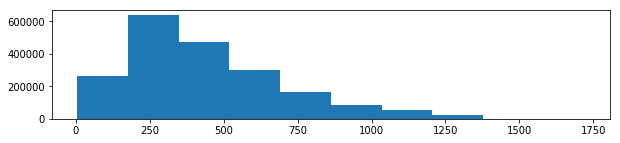

In [13]:
# INSTALLMENT
X = 'installment'
EDA_attr(X)
scale_attr(X)

In [14]:
# INT_RATE
X = 'int_rate'
EDA_attr(X)
ls_clean[X] = ls[X].str[:-1].astype(np.float)
scale_attr(X)

**int_rate**: Interest Rate on the loan

	Type: 			object
	Missing Values: 	0 (0.0%)
	Number of Categories: 	650
          count           sum
int_rate                     
 11.99%   53872 769423225.000
  5.32%   47171 690038950.000
 10.99%   44164 613296525.000


**loan_amnt**: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

	Type: 			float64
	Missing Values: 	0 (0.0%)
	Mean: 			14920.73
	Range: 			(500.00, 40000.00)


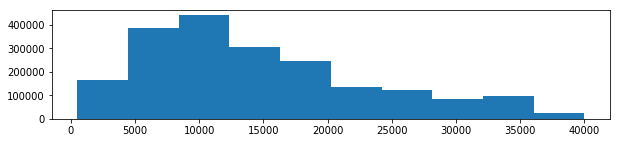

In [15]:
# LOAN_AMNT
X = 'loan_amnt'
EDA_attr(X)
scale_attr(X)

In [16]:
# PURPOSE
X = 'purpose'
EDA_attr(X)
dummy_attr(X)

**purpose**: A category provided by the borrower for the loan request. 

	Type: 			object
	Missing Values: 	0 (0.0%)
	Number of Categories: 	14
                      count             sum
purpose                                    
debt_consolidation  1137459 17981579625.000
credit_card          446668  6814273200.000
home_improvement     135001  1973988925.000


In [17]:
# SUB_GRADE
X = 'sub_grade'
EDA_attr(X)
mapping = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6}
ls_clean[X] = (ls[X].apply(lambda x: x[0]).map(mapping).astype(int)*5 +
               ls[X].apply(lambda x: x[1]).astype(int)).astype(int)
scale_attr(X)

**sub_grade**: LC assigned loan subgrade

	Type: 			object
	Missing Values: 	0 (0.0%)
	Number of Categories: 	35
            count            sum
sub_grade                       
C1         131882 1884162800.000
B5         126570 1723099175.000
B4         122532 1692566700.000


In [18]:
# TERM
X = 'term'
EDA_attr(X)
dummy_attr(X)

**term**: The number of payments on the loan. Values are in months and can be either 36 or 60.

	Type: 			object
	Missing Values: 	0 (0.0%)
	Number of Categories: 	2
              count             sum
term                               
 36 months  1432001 18128083000.000
 60 months   572061 11773980675.000


In [ ]:
# VERIFICATION_STATUS
X = 'verification_status'
EDA_attr(X)
dummy_attr(X)

**verification_status**: Indicates if income was verified by LC, not verified, or if the income source was verified

	Type: 			object
	Missing Values: 	0 (0.0%)
	Number of Categories: 	3
                      count             sum
verification_status                        
Source Verified      784628 11914964500.000
Not Verified         636247  7955207100.000
Verified             583187 10031892075.000


<hr style="height:1pt">

### 2B. Borrower Demographics

In [ ]:
# ADDR_STATE
X = 'addr_state'
EDA_attr(X)
dummy_attr(X)

In [ ]:
# ANNUAL_INC
X = 'annual_inc'
EDA_attr(X)
outliers = outlier_attr(X, 10000000)
scale_attr(X,fit_data=ls_clean[~outliers][[X]])

In [ ]:
# EMP_LENGTH
X = 'emp_length'
EDA_attr(X)
mapping = {'1 year': 1, '10+ years': 10, '2 years': 2, '3 years': 3, 
           '4 years': 4, '5 years': 5, '6 years': 6, '7 years': 7, 
           '8 years': 8, '9 years': 9, '< 1 year': 0}
ls_clean[X] = ls[X].map(mapping)
scale_attr(X)

In [ ]:
# HOME_OWNERSHIP
X = 'home_ownership'
EDA_attr(X)
ls_clean[X] = ls_clean[X].replace({'ANY':'OTHER', 'NONE':'OTHER'})
dummy_attr(X)

<hr style="height:1pt">

### 2C. Credit History Information

In [ ]:
# ACC_NOW_DELINQ
X = 'acc_now_delinq'
EDA_attr(X)
outliers = outlier_attr(X, 7)


In [ ]:
# ACC_OPEN_PAST_24MTHS
X = 'acc_open_past_24mths'
EDA_attr(X)
scale_attr(X)

In [ ]:
# ALL_UTIL
X = 'all_util'
EDA_attr(X)
scale_attr(X)

In [ ]:
# AVG_CUR_BAL
X = 'avg_cur_bal'
EDA_attr(X)
scale_attr(X)

In [ ]:
# BC_OPEN_TO_BUY
X = 'bc_open_to_buy'
EDA_attr(X)
scale_attr(X)

In [ ]:
# BC_UTIL: scaling
X = 'bc_util'
EDA_attr(X)
scale_attr(X)

In [ ]:
# CHARGEOFF_WITHIN_12_MTHS
X = 'chargeoff_within_12_mths'
EDA_attr(X)
scale_attr(X)

In [ ]:
# COLLECTIONS_12_MTHS_EX_MED
X = 'collections_12_mths_ex_med'
EDA_attr(X)
outliers = outlier_attr(X, 12)
scale_attr(X,fit_data=ls_clean[~outliers][[X]])

In [ ]:
# DELINQ_2YRS
X = 'delinq_2yrs'
EDA_attr(X)
scale_attr(X)

In [ ]:
# DELINQ_AMNT
X = 'delinq_amnt'
EDA_attr(X)
scale_attr(X)

In [ ]:
# DTI
X = 'dti'
EDA_attr(X)
ls_clean[ls[X]==-1] = np.NaN
scale_attr(X)

In [ ]:
# EARLIEST_CR_LINE
X = 'earliest_cr_line'
EDA_attr(X)

ls_clean[X] =  np.array((ls['issue_d'] - ls[X]).dt.days).reshape(-1,1)

scale_attr(X)

In [ ]:
# IL_UTIL
X = 'il_util'
EDA_attr(X)
scale_attr(X)

In [ ]:
# INQ_FI
X = 'inq_fi'
EDA_attr(X)
scale_attr(X)

In [ ]:
# INQ_LAST_12M
X = 'inq_last_12m'
EDA_attr(X)
scale_attr(X)

In [ ]:
# INQ_LAST_6MTHS
X = 'inq_last_6mths'
EDA_attr(X)
scale_attr(X)

In [ ]:
# MAX_BAL_BC
X = 'max_bal_bc'
EDA_attr(X)
scale_attr(X)

In [ ]:
# MO_SIN_OLD_IL_ACCT
X =  'mo_sin_old_il_acct'
EDA_attr(X)
scale_attr(X)

In [ ]:
# MO_SIN_OLD_REV_TL_OP
X =  'mo_sin_old_rev_tl_op'
EDA_attr(X)
scale_attr(X)

In [ ]:
# MO_SIN_RCNT_REV_TL_OP
X = 'mo_sin_rcnt_rev_tl_op'
EDA_attr(X)
scale_attr(X)

In [ ]:
# MO_SIN_RCNT_TL
X = 'mo_sin_rcnt_tl'
EDA_attr(X)
scale_attr(X)

In [ ]:
# MORT_ACC
X = 'mort_acc'
EDA_attr(X)
scale_attr(X)

In [ ]:
# MTHS_SINCE_LAST_DELINQ
X = 'mths_since_last_delinq'
EDA_attr(X)
scale_attr(X)

In [ ]:
# MTHS_SINCE_LAST_MAJOR_DEROG
X = 'mths_since_last_major_derog'
EDA_attr(X)
scale_attr(X)

In [ ]:
# MTHS_SINCE_LAST_RECORD
X = 'mths_since_last_record'
EDA_attr(X)
scale_attr(X)

In [ ]:
# MTHS_SINCE_RCNT_IL
X = 'mths_since_rcnt_il'
EDA_attr(X)
scale_attr(X)

In [ ]:
# MTHS_SINCE_RECENT_BC
X = 'mths_since_recent_bc'
EDA_attr(X)
scale_attr(X)

In [ ]:
# MTHS_SINCE_RECENT_BC_DLQ
X = 'mths_since_recent_bc_dlq'
EDA_attr(X)
scale_attr(X)

In [ ]:
# MTHS_SINCE_RECENT_INQ
X =  'mths_since_recent_inq'
EDA_attr(X)
scale_attr(X)

In [ ]:
# MTHS_SINCE_RECENT_REVOL_DELINQ
X= 'mths_since_recent_revol_delinq'
EDA_attr(X)
scale_attr(X)

In [ ]:
# NUM_ACCTS_EVER_120_PD
X = 'num_accts_ever_120_pd'
EDA_attr(X)
scale_attr(X)

In [ ]:
# NUM_ACTV_BC_TL
X = 'num_actv_bc_tl'
EDA_attr(X)
scale_attr(X)

In [ ]:
# NUM_ACTV_REV_TL
X = 'num_actv_rev_tl'
EDA_attr(X)
scale_attr(X)

In [ ]:
# NUM_BC_SATS
X = 'num_bc_sats'
EDA_attr(X)
scale_attr(X)

In [ ]:
# NUM_BC_TL
X =  'num_bc_tl'
EDA_attr(X)
scale_attr(X)

In [ ]:
# NUM_IL_TL
X = 'num_il_tl'
EDA_attr(X)
scale_attr(X)

In [ ]:
# NUM_OP_REV_TL
X = 'num_op_rev_tl'
EDA_attr(X)
scale_attr(X)

In [ ]:
# NUM_REV_ACCTS
X = 'num_rev_accts'
EDA_attr(X)
scale_attr(X)

In [ ]:
# NUM_REV_TL_BAL_GT_0
X = 'num_rev_tl_bal_gt_0'
EDA_attr(X)
scale_attr(X)

In [ ]:
# NUM_SATS
X = 'num_sats'
EDA_attr(X)
scale_attr(X)

In [ ]:
# NUM_TL_120DPD_2M
X = 'num_tl_120dpd_2m'
EDA_attr(X)
scale_attr(X)

In [ ]:
# NUM_TL_30DPD
X = 'num_tl_30dpd'
EDA_attr(X)
scale_attr(X)

In [ ]:
# NUM_TL_90G_DPD_24M
X = 'num_tl_90g_dpd_24m'
EDA_attr(X)
scale_attr(X)

In [ ]:
# NUM_TL_OP_PAST_12M
X = 'num_tl_op_past_12m'
EDA_attr(X)
scale_attr(X)

In [ ]:
# OPEN_ACC
X = 'open_acc'
EDA_attr(X)
scale_attr(X)

In [ ]:
# OPEN_ACC_6M
X = 'open_acc_6m'
EDA_attr(X)
scale_attr(X)

In [ ]:
# OPEN_ACT_IL
X = 'open_act_il'
EDA_attr(X)
scale_attr(X)

In [ ]:
# OPEN_ACT_12M
X = 'open_il_12m'
EDA_attr(X)
scale_attr(X)

In [ ]:
# OPEN_ACT_24M
X = 'open_il_24m'
EDA_attr(X)
scale_attr(X)

In [ ]:
# OPEN_RV_12M
X = 'open_rv_12m'
EDA_attr(X)
scale_attr(X)

In [ ]:
# OPEN_RV_24M
X = 'open_rv_24m'
EDA_attr(X)
scale_attr(X)

In [ ]:
# PCT_TL_NVR_DLQ
X = 'pct_tl_nvr_dlq'
EDA_attr(X)
scale_attr(X)

In [ ]:
# PERCENT_BC_GT_75
X = 'percent_bc_gt_75'
EDA_attr(X)
scale_attr(X)

In [ ]:
# PUB_REC
X ='pub_rec'
EDA_attr(X)
scale_attr(X)

In [ ]:
# PUB_REC_BANKRUPTCIES
X = 'pub_rec_bankruptcies'
EDA_attr(X)
scale_attr(X)

In [ ]:
# REVOL_BAL
X = 'revol_bal'
EDA_attr(X)
scale_attr(X)

In [ ]:
# REVOL_UTIL
X = 'revol_util'
EDA_attr(X)
ls_clean[X] = ls[X].str[:-1].astype(np.float)
scale_attr(X)

In [ ]:
# TAX_LIENS
X = 'tax_liens'
EDA_attr(X)
scale_attr(X)

In [ ]:
# TOT_COLL_AMT
X = 'tot_coll_amt'
EDA_attr(X)
scale_attr(X)

In [ ]:
# TOT_CUR_BAL
X = 'tot_cur_bal'
EDA_attr(X)
scale_attr(X)

In [ ]:
# TOT_HI_CRED_LIM
X = 'tot_hi_cred_lim'
EDA_attr(X)
scale_attr(X)

In [ ]:
# TOTAL_ACC
X = 'total_acc'
EDA_attr(X)
scale_attr(X)

In [ ]:
# TOTAL_BAL_EX_MORT
X = 'total_bal_ex_mort'
EDA_attr(X)
scale_attr(X)

In [ ]:
# TOTAL_BAL_IL
X = 'total_bal_il'
EDA_attr(X)
scale_attr(X)

In [ ]:
# TOTAL_BC_LIMIT
X = 'total_bc_limit'
EDA_attr(X)
scale_attr(X)

In [ ]:
# TOTAL_CU_TL
X = 'total_cu_tl'
EDA_attr(X)
scale_attr(X)

In [ ]:
# TOTAL_IL_HIGH_CREDIT_LIMIT
X = 'total_il_high_credit_limit'
EDA_attr(X)
scale_attr(X)

In [ ]:
# TOTAL_REV_HI_LIM
X = 'total_rev_hi_lim'
EDA_attr(X)
scale_attr(X)

<hr style="height:2pt">

### 2D. Co-Borrower Information

In [ ]:
# APPLICATION_TYPE
X = 'application_type'
EDA_attr(X)
dummy_attr(X)

In [ ]:
# ANNUAL_INC_JOINT
X = 'annual_inc_joint'
EDA_attr(X)
outliers = outlier_attr(X, 10000000)
scale_attr(X, ls[~outliers][[X]])

In [ ]:
# DTI_JOINT
X = 'dti_joint'
EDA_attr(X)
scale_attr(X)

In [ ]:
# REVOL_BAL_JOINT
X = 'revol_bal_joint'
EDA_attr(X)
scale_attr(X)

In [ ]:
# SEC_APP_CHARGEOFF_WITHIN_12_MTHS
X ='sec_app_chargeoff_within_12_mths'
EDA_attr(X)
scale_attr(X)

In [ ]:
# SEC_APP_COLLECTIONS_12_MTHS_EX_MED
X = 'sec_app_collections_12_mths_ex_med'
EDA_attr(X)
outliers = outlier_attr(X, 12)
scale_attr(X, ls[~outliers][[X]])

In [ ]:
# SEC_APP_EARLIEST_CR_LINE
X = 'sec_app_earliest_cr_line'
EDA_attr(X)
ls_clean[X] =  np.array((ls['issue_d'] - ls[X]).dt.days).reshape(-1,1)
scale_attr(X)

In [ ]:
# SEC_APP_INQ_LAST_6MTHS
X = 'sec_app_inq_last_6mths'
EDA_attr(X)
scale_attr(X)

In [ ]:
# SEC_APP_MORT_ACC
X = 'sec_app_mort_acc'
EDA_attr(X)
outliers = outlier_attr(X, 15)
scale_attr(X, ls[~outliers][[X]])

In [ ]:
# SEC_APP_MTHS_SINCE_LAST_MAJOR_DEROG
X = 'sec_app_mths_since_last_major_derog'
EDA_attr(X)
scale_attr(X)

In [ ]:
# SEC_APP_NUM_REV_ACCTS
X = 'sec_app_num_rev_accts'
EDA_attr(X)
scale_attr(X)

In [ ]:
# SEC_APP_OPEN_ACC
X = 'sec_app_open_acc'
EDA_attr(X)
scale_attr(X)

In [ ]:
# SEC_APP_OPEN_ACT_IL
X = 'sec_app_open_act_il'
EDA_attr(X)
scale_attr(X)

In [ ]:
# SEC_APP_REVOL_UTIL
X = 'sec_app_revol_util'
EDA_attr(X)
scale_attr(X)

In [ ]:
# VERIFICATION_STATUS_JOINT
X = 'verification_status_joint'
EDA_attr(X)
dummy_attr(X)

<hr style="height:5pt">

## 3. Dependent Variable Feature Design (36 variables)

In [ ]:
# DEPENDENT VARIABLES
dependent_cols = [
    
    # Payment Variables (11): 
    'issue_d', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_status', 
    'next_pymnt_d', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 
    'total_pymnt_inv', 'total_rec_int', 'total_rec_prncp', 
    
    # Hardship/Collections/Settlements
    'collection_recovery_fee', 'debt_settlement_flag', 'debt_settlement_flag_date', 'deferral_term', 
    'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_flag', 
    'hardship_last_payment_amount','hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 
    'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type',
    'last_credit_pull_d', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'pymnt_plan', 
    'recoveries', 'settlement_amount', 'settlement_date', 'settlement_percentage', 
    'settlement_status', 'settlement_term', 'total_rec_late_fee', ]

ls_clean.drop(dependent_cols, axis=1, inplace=True)

There are three features that we will design to represent the outcome of loan:
- A. **Outcome Classification** (Repaid/Current vs. Not Repaid/Current)
- B. **Principal Repaid Percentage**
- C. **Annual Percentage Rate of Return** (APR)

Our focus will be on loans that have completed their terms. This subset of loans provides the most complete outcome information. In-force loans cannot provide conclusive inferences on loan outcomes because the full term has not completed. Therefore information

### A. `OUT_Class`

In [ ]:
print(ls.groupby('loan_status')['loan_amnt'].count())
len(ls['loan_status'])

In [ ]:
ls_clean['OUT_Class'] = 0
ls_clean.loc[ls['loan_status'].str.contains('Fully Paid'), 'OUT_Class'] = 1
ls_clean.loc[ls['loan_status'].str.contains('Current'), 'OUT_Class'] = 1

In [ ]:
print(ls_clean.groupby('OUT_Class')['loan_amnt'].count())
len(ls['loan_status'])

### B. `OUT_Prncp_Repaid_Percentage`

In [ ]:
ls_clean['OUT_Prncp_Repaid_Percentage'] = ls['total_rec_prncp'] / ls['loan_amnt']

In [ ]:
ls_clean['OUT_Prncp_Repaid_Percentage'].describe()

### C. `OUT_APR`

In [ ]:
# print(ls[['loan_amnt','term','int_rate','total_pymnt', 'installment', 'loan_status']].head(10))

# def calculat_EAR():
#     months = 36
#     loan_amnt= 5000
#     total_pymnt = 5863.155
#     cashflows = np.insert(np.full(months, total_pymnt/months), 0 , -loan_amnt)
#     monthly_IRR = np.irr(df)
    
# print((ls['last_pymnt_d'].dt.to_period('M') - ls['issue_d'].dt.to_period('M')).head(10))
# print(ls['loan_status'].head(10))

<hr style="height:5pt">

## 4. Final Processing

In [ ]:
# DROP OUTLIERS
ls_clean2 = ls_clean[ls_clean['outlier']==0]
ls_clean2 = ls_clean2.drop('outlier', axis=1)

In [ ]:
# DROP TERM INCOMPLETE LOANS
completed_36 = (ls['issue_d'] < '2015-04-01') & (ls['term']  == ' 36 months')
completed_60 = (ls['issue_d'] < '2013-04-01') & (ls['term']  == ' 60 months')
ls_clean3 = ls_clean2[completed_36 | completed_60]

In [ ]:
# EXPORT DATASET
ls_clean2.to_hdf(directory + 'LS_CLEAN.h5', 'LS_CLEAN')
ls_clean3.to_hdf(directory + 'LS_CLEAN_COMPLETED.h5', 'LS_CLEAN_COMPLETED')